# **Lesson 8. 서울시 따릉이 대여량 분석 및 예측**

* 실습 배경
    * 평소 따릉이를 자주 이용하는 A씨는 최근 서울시에서 진행하고 있는 따릉이 활성화 방안 제안 공모전 참가를 희망하고 있습니다. 
    * 때마침 회사에서 [Python을 활용한 실전 데이터 분석]  과정을 우수한 성적으로 수료했기에 공모전 참가에 적기라고 생각되었죠!
    * 그렇다면, 주어진 따릉이 운영 데이터를 활용해 대여량을 분석하고 이용자가 필요할 때 부족하지 않도록 채우는 방안을 제안해 봅시다. 

* 데이터 분석 목표
    * ① 시간대별 대여량에 영향을 주는 요인 도출
    * ② 시계열에 맞는 시각화 분석

## **1.환경준비**

### **(1) 라이브러리 로딩**

In [ ]:
# jupyter lite에서 패키지 설치
import piplite
await piplite.install("seaborn")

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic   

### **(2) 데이터 로딩**

|	변수명	|	설명	|	구분	|  데이터 유형 |
|----|----|----|----|
|	Date 	|	 날짜	|	Target	| datetime |
|	Hour	|	시간대	|	feature	| 범주형 |
|	Count	|	 대여량	|	feature	| 수치형 |
|	Count_B2 	|	 2시간전 대여량 	|	feature	| 수치형 |
|	Temp_B2	|	 2시간전 온도	|	feature	| 수치형 |
|	Hum_B2 	|	 2시간전 습도	|	feature	| 수치형 |
|	Weekday 	|	 요일 	|	feature	| 범주형 |


In [ ]:
path = 'SeoulBike.csv'
data = pd.read_csv(path)
data['Date'] = pd.to_datetime(data['Date'])

## **2.기본 탐색**

### **(1) 상위, 하위 5개의 정보 확인**
* .head()
* .tail()

In [ ]:
data.head()

In [ ]:
data.tail()

### **(2) 데이터프레임 정보 확인**
* .info()

In [ ]:
data.info()

## **3.시계열 데이터 시각화**

### **(1) 기초통계량**

* 기초통계량 : .describe()

In [ ]:
data.describe()

### **(2) 라인차트**

#### **1) 전체 기간에 대한 라인차트 그리기**

In [ ]:
# 대여량(Count)에 대해서 라인차트 그리기
plt.figure(figsize = (10, 4))
plt.plot('Count', data = data)
plt.grid()
plt.show()

#### **2) 2018년11월에 대한 라인차트 그리기**

In [ ]:
# 연도와 기간 조건으로 조회해서 temp로 저장
temp = data.loc[(data['Date'].dt.year == 2018) & (data['Date'].dt.month == 11 )]

# 해당 기간에 대한 라인차트 그리기
plt.figure(figsize = (10, 4))
plt.plot('Count', data = temp)
plt.grid()
plt.show()

* 파악한 내용을 적어 봅시다.

In [ ]:
# 주간단위 패턴 : 평일과 주말의 대여량 패턴이 다르다.
# 일단위 : 출,퇴근 시간대와 그외 시간대 패턴이 다르다.

#### **3) 이동평균선 추가**
* 24시간 이동평균 대여량(Count_B2)를 추가하고
* 라인차트를 그려봅시다.

In [ ]:
# 24시간 이동평균 대여량(Count_B2)를 추가
data['Count_B2_MA24'] = data['Count_B2'].rolling(24, min_periods = 1).mean()

# 해당 기간에 대한 라인차트 그리기
plt.figure(figsize = (10, 4))
plt.plot('Count', data = data, label = 'Count')
plt.plot('Count_B2_MA24', data = data, label = 'Count_B2_MA24')
plt.legend()
plt.grid()
plt.show()


* 추세를 파악해 봅시다.

In [ ]:
# 계절에 따라 대여량에 차이가 있다.
# 겨울이 제일 낮고, 여름이 제일 높다
# 봄보다 가을 대여량이 더 높다.


## **4. 시계열 패턴 추가**
* 패턴으로부터 파악한 내용을 변수로 생성해 봅시다.
    * 다음 변수를 생성합니다.
        * 24시간 전 대여량(Count)
        * 시간대 구분(Hour)
            * 7~8 : 1
            * 17~20 : 2
            * 나머지 : 0
    * 2시간 후의 대여량을 예측하는데, 더 필요한 변수가 있다면 생성해 봅시다.
        * 예 : 최근 3시간 평균 온도, 평일/주말 여부 등
        

### **(1) 주어진 패턴을 변수로 추가하기**

#### **1) 24시간 전 대여량(Count)**
* .shift()

In [ ]:
data['Count_B24'] = data['Count'].shift(24)
data.head(30)

#### **2) 시간대 구분(Hour)**
* .map 이용
    * 7~8 : 1
    * 17~20 : 2
    * 나머지 : 0

In [ ]:
data['Hour_Group'] = data['Hour'].map({0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:1,8:1,9:0,10:0,11:0,12:0,13:0,14:0,15:0,
                                       16:0,17:2,18:2,19:2,20:2,21:0,22:0,23:0})
data.head(10)

### **(2) 추가변수 만들기**

In [ ]:
data['Weekday'].unique()

In [ ]:
# 예 : 최근 3시간 평균 온도, 평일/주말 여부 등

data['Temp_MA3'] = data['Temp_B2'].rolling(3, min_periods = 1).mean()
data['Weekend'] = data['Weekday'].map({'Fri':0, 'Sat':1, 'Sun':1, 'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0})
data.head()

## **5.예측 모델링**
* 여러분이 추가한 변수가 무엇인지에 따라 모델의 성능이 달라집니다.

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

### **(1) 데이터 준비**
* 모델링을 위해서는 데이터가 특별한 형태로 준비되어야 합니다.
    * 본 실습에서는 준비에 대한 세세한 내용을 다루지는 않습니다.
    * 가변수화 : 범주형 --> 수치형 변환
    * 데이터 분할 : 학습용과 검증용 분할
        * 학습용 : 모델링 용도
        * 검증용 : 모델 성능 측정(검증)

In [116]:
# 결측치 조치
data.dropna(inplace = True)

In [117]:
# 데이터 분할1 : x, y 분할
target = 'Count'
x = data.drop([target,'Date','Weekday'], axis = 1)
y = data[target]

In [118]:
# 가변수화
category_cols = ['Hour_Group','Hour']
x = pd.get_dummies(x, columns = category_cols, drop_first = True)

In [119]:
# 데이터 분할2 : 학습용 : 검증용
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 24*14, shuffle = False)

### **(2) 모델링 및 평가**

* 모델링 절차
    * 선언
    * 학습(모델링) : x_train, y_train
    * 예측 : x_test
    * 평가 : y_test, 예측값

* 아래 주석으로 되어 있는 코드를 그대로 작성해 봅시다.

In [120]:
# 선언 : model = LinearRegression()
model = LinearRegression()

In [121]:
# 학습 : model.fit(x_train, y_train)
model.fit(x_train, y_train)


LinearRegression()

In [122]:
# 예측 : pred = model.predict(x_test)
pred = model.predict(x_test)

In [123]:
# 평가(평균오차) : mean_absolute_error(y_test, pred)
mean_absolute_error(y_test, pred)

140.28226942592448

* 모델 시각화

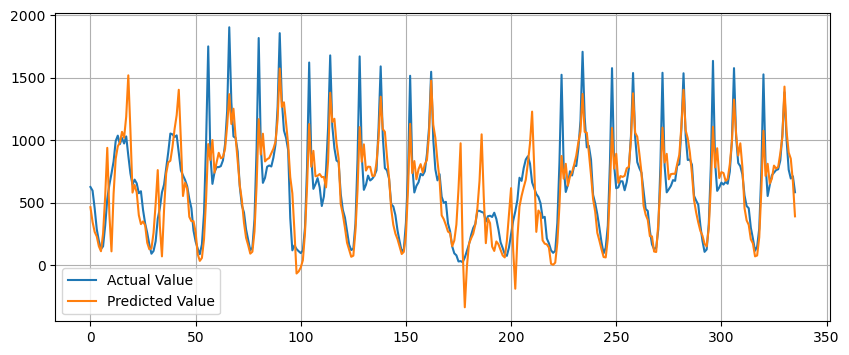

In [124]:
plt.figure(figsize = (10,4))
plt.plot(y_test.values, label = 'Actual Value')
plt.plot(pred, label = 'Predicted Value')
plt.legend()
plt.grid()
plt.show()